In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 65.9MB 58kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor,cv,Pool
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/janta hack/train_file.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/janta hack/test_file.csv')

In [ ]:
train.head()

ID             datetime  ...  var2  electricity_consumption
0   0  2013-07-01 00:00:00  ...     A                    216.0
1   1  2013-07-01 01:00:00  ...     A                    210.0
2   2  2013-07-01 02:00:00  ...     A                    225.0
3   3  2013-07-01 03:00:00  ...     A                    216.0
4   4  2013-07-01 04:00:00  ...     A                    222.0

[5 rows x 8 columns]

In [ ]:
test.head()

ID             datetime  temperature  var1  pressure  windspeed var2
0  552  2013-07-24 00:00:00        -10.0 -16.4    1011.0    263.280    A
1  553  2013-07-24 01:00:00        -10.0 -20.7    1011.0    267.175    A
2  554  2013-07-24 02:00:00        -10.7 -17.1    1003.0    269.555    A
3  555  2013-07-24 03:00:00        -13.6 -20.7    1008.0    273.060    A
4  556  2013-07-24 04:00:00        -10.7 -17.1    1006.0      1.765    A

In [ ]:
train['var2'].unique()

array(['A', 'B', 'C'], dtype=object)

In [ ]:
test['electricity_consumption'] = 0

In [ ]:
train['datetime'] = pd.to_datetime(train['datetime'],format='%Y-%m-%d %H:%M')
test['datetime'] = pd.to_datetime(test['datetime'],format='%Y-%m-%d %H:%M')

In [ ]:
df = pd.merge(train,test,on=['ID','datetime','temperature','var1','pressure','windspeed','var2','electricity_consumption'],how='outer')
df.sort_values(by='datetime',inplace=True)
df.head()

ID            datetime  temperature  ...  windspeed  var2  electricity_consumption
0   0 2013-07-01 00:00:00        -11.4  ...    571.910     A                    216.0
1   1 2013-07-01 01:00:00        -12.1  ...    575.040     A                    210.0
2   2 2013-07-01 02:00:00        -12.9  ...    578.435     A                    225.0
3   3 2013-07-01 03:00:00        -11.4  ...    582.580     A                    216.0
4   4 2013-07-01 04:00:00        -11.4  ...    586.600     A                    222.0

[5 rows x 8 columns]

In [ ]:
df.fillna(0,inplace=True)
scaler = StandardScaler()
df['pressure'] = scaler.fit_transform(df['pressure'].values.reshape(-1,1))
df['windspeed'] = scaler.fit_transform(df['windspeed'].values.reshape(-1,1))

In [ ]:
df['hour'] = df.datetime.dt.hour
df['day'] = df.datetime.dt.day
df['month'] = df.datetime.dt.month
df['year'] = df.datetime.dt.year

In [ ]:
df.drop('ID',axis=1,inplace=True)
df.set_index('datetime',inplace=True)
df.head()

temperature  var1  pressure  ...  day month  year
datetime                                          ...                 
2013-07-01 00:00:00        -11.4 -17.1  1.377193  ...    1     7  2013
2013-07-01 01:00:00        -12.1 -19.3  0.795712  ...    1     7  2013
2013-07-01 02:00:00        -12.9 -20.0  1.127987  ...    1     7  2013
2013-07-01 03:00:00        -11.4 -17.1  0.712643  ...    1     7  2013
2013-07-01 04:00:00        -11.4 -19.3  1.543331  ...    1     7  2013

[5 rows x 10 columns]

In [ ]:
plt.rcParams['figure.figsize'] = 12,6

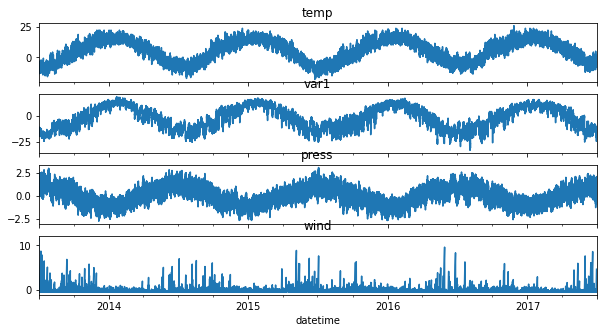

In [ ]:
fig,axs = plt.subplots(4,1,sharex=True)
df['temperature'].plot(figsize=(10,5),title='temp',ax=axs[0])
df['var1'].plot(figsize=(10,5),title='var1',ax=axs[1])
df['pressure'].plot(figsize=(10,5),title='press',ax=axs[2])
df['windspeed'].plot(figsize=(10,5),title='wind',ax=axs[3])
plt.show()

In [ ]:
for i in ['temperature','pressure','var1']:
  df[f'cosine_{i}'] = df[i].apply(lambda x: np.cos(x))
  df[f'sine_{i}'] = df[i].apply(lambda x: np.sin(x))

In [ ]:
def feature_gen(data):
  for i in ['day','month','year']:
    group = data[['temperature','var1','pressure','windspeed','electricity_consumption',i]].groupby(i).agg(['mean','min','max','std'])
    group.columns = ['_'.join(x)+f'_{i}' for x in group.columns.ravel()]
    data = pd.merge(data,group,on=i,how='left')
  return data

In [ ]:
df = feature_gen(df)
df.head()

temperature  ...  electricity_consumption_std_year
0        -11.4  ...                         160.60273
1        -12.1  ...                         160.60273
2        -12.9  ...                         160.60273
3        -11.4  ...                         160.60273
4        -11.4  ...                         160.60273

[5 rows x 76 columns]

In [ ]:
df['log_wind'] = np.log1p(df['windspeed'])

group = df[['temperature','var1','pressure','windspeed','var2','day','month','year']].groupby('var2').agg({
    'temperature':['mean','min','max','std'],
    'var1':['mean','min','max','std'],
    'pressure':['mean','min','max','std'],
    'windspeed':['mean','min','max','std'],
    'day':['count'],
    'month':['count'],
    'year':['count']})
group.columns = ['_'.join(x)+'_var2' for x in group.columns.ravel()]
df = pd.merge(df,group,on='var2',how='left')

df['temp_diff_var1'] = abs(df['temperature']) - abs(df['var1'])
df.head()

temperature  var1  ...  year_count_var2  temp_diff_var1
0        -11.4 -17.1  ...            33416            -5.7
1        -12.1 -19.3  ...            33416            -7.2
2        -12.9 -20.0  ...            33416            -7.1
3        -11.4 -17.1  ...            33416            -5.7
4        -11.4 -19.3  ...            33416            -7.9

[5 rows x 97 columns]

In [ ]:
le = LabelEncoder()
df['var2'] = le.fit_transform(df['var2'])
df['year'] = le.fit_transform(df['year'])

In [ ]:
X = df[df['electricity_consumption'] > 0]
X_valid = df[df['electricity_consumption'] == 0]

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=None)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    model_xgb = alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
        
    #Print model report:
    print("\nModel Report")
    print("\nNumber of trees used: %d" %(cvresult.shape[0]))
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(dtrain[target].values, dtrain_predictions)))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances',figsize=(6,15))
    plt.ylabel('Feature Importance Score')
    return model_xgb


Model Report

Number of trees used: 3534
RMSE : 13.42


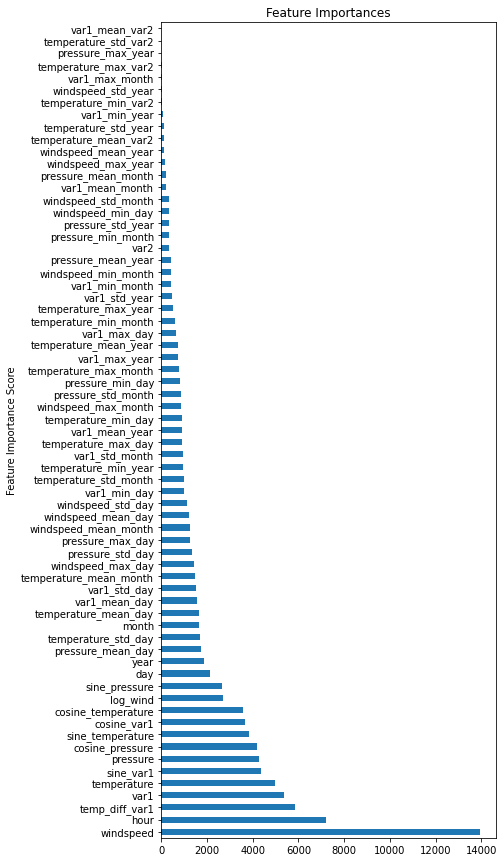

In [ ]:
target = 'electricity_consumption'
predictors = [x for x in X.columns if x not in [target]]
xgbr1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=4000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 objective='reg:squarederror')
model = modelfit(xgbr1, X, predictors)

In [ ]:
xgbr2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=3534,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 objective='reg:squarederror')
model_xgbr2 = xgbr2.fit(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'])
y_pred_xgbr2 = xgbr2.predict(X_valid.drop(['electricity_consumption'],axis=1))

In [ ]:
test_res = test[['ID']]
test_res = pd.concat([test_res,pd.DataFrame(y_pred_xgbr2,columns=['electricity_consumption'])],axis=1)
test_res.set_index('ID',inplace=True)
test_res.to_csv('/content/drive/My Drive/Colab Notebooks/janta hack/sub_xgbr2.csv')

In [ ]:
X

temperature  var1  ...  year_count_var2  temp_diff_var1
0            -11.4 -17.1  ...            33416            -5.7
1            -12.1 -19.3  ...            33416            -7.2
2            -12.9 -20.0  ...            33416            -7.1
3            -11.4 -17.1  ...            33416            -5.7
4            -11.4 -19.3  ...            33416            -7.9
...            ...   ...  ...              ...             ...
34891         -0.7 -15.0  ...            33416           -14.3
34892         -2.9 -11.4  ...            33416            -8.5
34893         -1.4 -12.9  ...            33416           -11.5
34894         -2.9 -11.4  ...            33416            -8.5
34895         -2.1 -11.4  ...            33416            -9.3

[26496 rows x 85 columns]

In [ ]:
ctr = CatBoostRegressor(iterations=4000,learning_rate=0.1,depth=5,loss_function='RMSE',od_wait=100,od_type='Iter')
cat_feat = np.where(X.drop(['electricity_consumption'],axis=1).dtypes != np.float)[0]
cv = cv(pool=Pool(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'],cat_features=cat_feat),params=ctr.get_params(),nfold=5,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 289.4123250	test: 289.4062259	best: 289.4062259 (0)	total: 433ms	remaining: 28m 51s
1:	learn: 264.2834648	test: 264.2840455	best: 264.2840455 (1)	total: 759ms	remaining: 25m 17s
2:	learn: 242.3994348	test: 242.4026991	best: 242.4026991 (2)	total: 1.05s	remaining: 23m 26s
3:	learn: 222.6933326	test: 222.6978831	best: 222.6978831 (3)	total: 1.36s	remaining: 22m 42s
4:	learn: 204.7582475	test: 204.7730727	best: 204.7730727 (4)	total: 1.69s	remaining: 22m 30s
5:	learn: 189.1880003	test: 189.1982263	best: 189.1982263 (5)	total: 1.99s	remaining: 22m 6s
6:	learn: 175.2914718	test: 175.2987663	best: 175.2987663 (6)	total: 2.28s	remaining: 21m 42s
7:	learn: 163.3439696	test: 163.3563327	best: 163.3563327 (7)	total: 2.59s	remaining: 21m 30s
8:	learn: 152.4532899	test: 152.4681751	best: 152.4681751 (8)	total: 2.86s	remaining: 21m 7s
9:	learn: 142.9294180	test: 142.9540375	best: 142.9540375 (9)	total: 3.17s	remaining: 21m 6s
10:	learn: 134.7531046	test: 134.7873342	best: 134.7873342 (10)

In [ ]:
model_ctr = ctr.fit(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'])
y_pred_ctr = ctr.predict(X_valid.drop(['electricity_consumption'],axis=1))
test_res_ctr = test[['ID']]
test_res_ctr = pd.concat([test_res_ctr,pd.DataFrame(y_pred_ctr,columns=['electricity_consumption'])],axis=1)
test_res_ctr.set_index('ID',inplace=True)
test_res_ctr.to_csv('/content/drive/My Drive/Colab Notebooks/janta hack/sub_ctr.csv')

0:	learn: 104.9498199	total: 14.5ms	remaining: 57.9s
1:	learn: 102.3249892	total: 28.2ms	remaining: 56.4s
2:	learn: 100.0903248	total: 41.9ms	remaining: 55.8s
3:	learn: 98.2423270	total: 54.7ms	remaining: 54.7s
4:	learn: 96.6009626	total: 68.2ms	remaining: 54.5s
5:	learn: 95.1584210	total: 82.5ms	remaining: 54.9s
6:	learn: 93.8787552	total: 95.3ms	remaining: 54.3s
7:	learn: 92.7550153	total: 108ms	remaining: 54s
8:	learn: 91.6038773	total: 121ms	remaining: 53.6s
9:	learn: 90.7376666	total: 134ms	remaining: 53.3s
10:	learn: 89.6385640	total: 148ms	remaining: 53.6s
11:	learn: 88.7546815	total: 161ms	remaining: 53.5s
12:	learn: 87.9385935	total: 175ms	remaining: 53.8s
13:	learn: 87.2014843	total: 188ms	remaining: 53.6s
14:	learn: 86.5894697	total: 201ms	remaining: 53.4s
15:	learn: 86.0505436	total: 217ms	remaining: 54s
16:	learn: 85.3519198	total: 240ms	remaining: 56.2s
17:	learn: 84.8655997	total: 252ms	remaining: 55.8s
18:	learn: 84.4165195	total: 263ms	remaining: 55.2s
19:	learn: 83.98

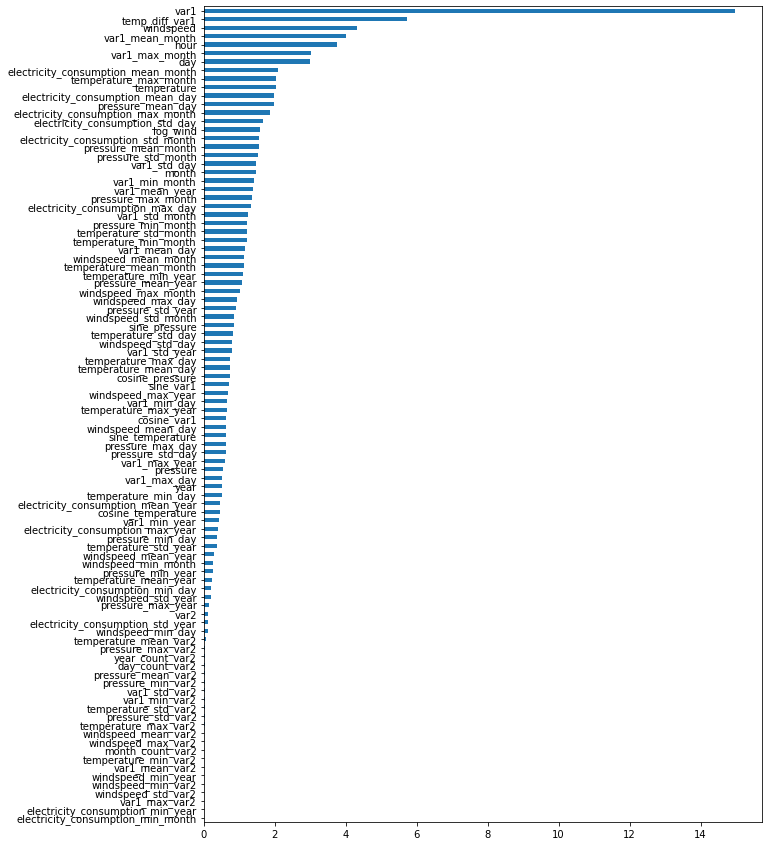

In [ ]:
importance = ctr.feature_importances_
fi = pd.Series(index = X.drop(['electricity_consumption'],axis=1).columns, data = importance)
fi.sort_values(ascending=False)[0::][::-1].plot(kind = 'barh',figsize=(10,15))

In [ ]:
params = {'num_leaves':31,'max_depth':5,'learning_rate':0.1,'n_estimators':4000,'metric':'mse'}
lgbr1 = lgb.LGBMRegressor(num_leaves=31,max_depth=5,learning_rate=0.1,n_estimators=4000,random_state=27,metric='mse')
cat_feat = np.where(X.drop(['electricity_consumption'],axis=1).dtypes != np.float)[0]
dtrain = lgb.Dataset(X.drop(['electricity_consumption'],axis=1),label=X['electricity_consumption'])
cv_lgb = lgb.cv(params=params,train_set=dtrain,nfold=5,stratified=False,verbose_eval=True)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	cv_agg's l2: 10931.9 + 604.936
[2]	cv_agg's l2: 10315.2 + 581.507
[3]	cv_agg's l2: 9790.37 + 553.17
[4]	cv_agg's l2: 9354.11 + 534.563
[5]	cv_agg's l2: 8981.82 + 531.574
[6]	cv_agg's l2: 8641.86 + 524.332
[7]	cv_agg's l2: 8333.42 + 512.573
[8]	cv_agg's l2: 8056.61 + 497.717
[9]	cv_agg's l2: 7823.84 + 486.098
[10]	cv_agg's l2: 7593.13 + 472.628
[11]	cv_agg's l2: 7378.79 + 453.473
[12]	cv_agg's l2: 7210.54 + 459.477
[13]	cv_agg's l2: 7034 + 437.971
[14]	cv_agg's l2: 6887.16 + 432.944
[15]	cv_agg's l2: 6749.36 + 418.539
[16]	cv_agg's l2: 6616.6 + 410.941
[17]	cv_agg's l2: 6510.58 + 400.01
[18]	cv_agg's l2: 6415.5 + 399.581
[19]	cv_agg's l2: 6314.59 + 396.864
[20]	cv_agg's l2: 6242.91 + 397.89
[21]	cv_agg's l2: 6150.42 + 386.74
[22]	cv_agg's l2: 6070.84 + 387.553
[23]	cv_agg's l2: 6008.89 + 371.798
[24]	cv_agg's l2: 5952.69 + 363.425
[25]	cv_agg's l2: 5898.16 + 361.959
[26]	cv_agg's l2: 5853.59 + 362.215
[27]	cv_agg's l2: 5807.58 + 350.486
[28]	cv_agg's l2: 5747.11 + 331.429
[29]	cv_ag

In [ ]:
lgbr1 = lgb.LGBMRegressor(num_leaves=31,max_depth=5,learning_rate=0.1,n_estimators=4000,random_state=27,metric='mse')
model_lgbr1 = lgbr1.fit(X.drop(['electricity_consumption'],axis=1),X['electricity_consumption'])
y_pred_lgbr1 = lgbr1.predict(X_valid.drop(['electricity_consumption'],axis=1))
test_res_lgbr = test[['ID']]
test_res_lgbr = pd.concat([test_res_lgbr,pd.DataFrame(y_pred_lgbr1,columns=['electricity_consumption'])],axis=1)
test_res_lgbr.set_index('ID',inplace=True)
test_res_lgbr.to_csv('/content/drive/My Drive/Colab Notebooks/janta hack/sub_lgbr.csv')

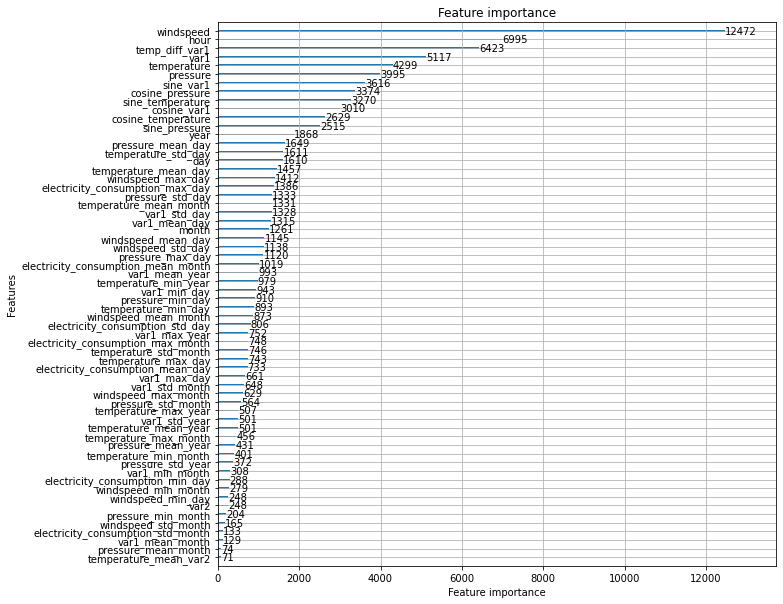

In [ ]:
lgb.plot_importance(booster=lgbr1,figsize=(10,10))